In [1]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
image_path = "plant_images/8-28-23-HerbsMaize-InHouse_828-091-BeanDragon-WW_2023-08-29_13-35-50.743_17880100_Vis_SV_0.png"

In [ ]:
def segment(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output_dir = "segmentation_output/" + image_path[13:-4] + '/'
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    
    os.mkdir(output_dir)
    
    cv2.imwrite(os.path.join(output_dir, "original_image.png"), cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
    
    # Convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define a precise range for brown shades
    lower_brown = np.array([0, 62, 0])  # Lower bound for brown
    upper_brown = np.array([16, 118, 143])  # Upper bound for brown

    # Create a mask for brown colors
    mask = cv2.inRange(image_hsv, lower_brown, upper_brown)
    
    plt.subplot(2, 3, 2)
    plt.title("Brown Color Mask")
    plt.imshow(mask, cmap="gray")
    
    cv2.imwrite(os.path.join(output_dir, "brown_color_mask.png"), mask)
    
    # Enhance edges using the Canny edge detector
    edges = cv2.Canny(mask, 50, 150)
    
    plt.subplot(2, 3, 3)
    plt.title("Edges")
    plt.imshow(edges, cmap="gray")
    
    cv2.imwrite(os.path.join(output_dir, "edges.png"), edges)

    # Combine the mask and edges for better segmentation
    combined_mask = cv2.bitwise_or(mask, edges)

    # Apply morphological operations to clean and emphasize structure
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    plt.subplot(2, 3, 4)
    plt.title("Morphological Operations")
    plt.imshow(combined_mask, cmap="gray")
    cv2.imwrite(os.path.join(output_dir, "morph.png"), combined_mask)

    # Apply the rectangle mask to all masks
    # Define the rectangle coordinates
    top_left = (883, 963)
    bottom_right = (3697, 5577)

    # Create a mask for the rectangle region
    rectangle_mask = np.zeros_like(mask, dtype=np.uint8)
    cv2.rectangle(rectangle_mask, top_left, bottom_right, 255, -1)
    
    plt.subplot(2, 3, 5)
    plt.title("Artifact Filtering")
    plt.imshow(rectangle_mask, cmap="gray")
    cv2.imwrite(os.path.join(output_dir, "crop.png"), rectangle_mask)

    # Apply the rectangle mask to each intermediate mask
    # mask = cv2.bitwise_and(mask, rectangle_mask)
    # edges = cv2.bitwise_and(edges, rectangle_mask)
    # combined_mask = cv2.bitwise_and(combined_mask, rectangle_mask)
    cleaned_mask = cv2.bitwise_and(cleaned_mask, rectangle_mask)
    

    # Remove edge artifacts using a mask
    # Define a mask that excludes image edges
    # height, width = cleaned_mask.shape
    # edge_mask = np.zeros_like(cleaned_mask, dtype=np.uint8)
    # cv2.rectangle(edge_mask, (50, 50), (width - 50, height - 50), 255, -1)

    # Apply the edge mask to the cleaned mask
    # final_mask = cv2.bitwise_and(cleaned_mask, cleaned_mask, mask=edge_mask)


    # Extract the segmented stem from the original image
    # segmented_stem = cv2.bitwise_and(image_rgb, image_rgb, mask=final_mask)
    segmented_stem = cv2.bitwise_and(image_rgb, image_rgb, mask=cleaned_mask)
    
    plt.subplot(2, 3, 6)
    plt.title("Segmented Stake")
    plt.imshow(segmented_stem)
    cv2.imwrite(os.path.join(output_dir, "segmented_stem.png"), cv2.cvtColor(segmented_stem, cv2.COLOR_RGB2BGR))
    
    # Save all images to the output folder
    
    

    # Display results
    # plt.figure(figsize=(15, 10))
    # plt.subplot(2, 3, 1)
    # plt.title("Original Image")
    # plt.imshow(image_rgb)
    # plt.subplot(2, 3, 2)
    # plt.title("Brown Color Mask")
    # plt.imshow(mask, cmap="gray")
    # plt.subplot(2, 3, 3)
    # plt.title("Edges")
    # plt.imshow(edges, cmap="gray")
    # plt.subplot(2, 3, 4)
    # plt.title("Combined Mask")
    # plt.imshow(combined_mask, cmap="gray")
    # plt.subplot(2, 3, 5)
    # plt.title("Edge Filtered Mask")
    # plt.imshow(cleaned_mask, cmap="gray")
    # plt.subplot(2, 3, 6)
    # plt.title("Segmented Stem")
    # plt.imshow(segmented_stem)
    # plt.tight_layout()
    # plt.savefig(os.path.join(output_dir, "figure.svg"))

    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "figure.svg"))
    

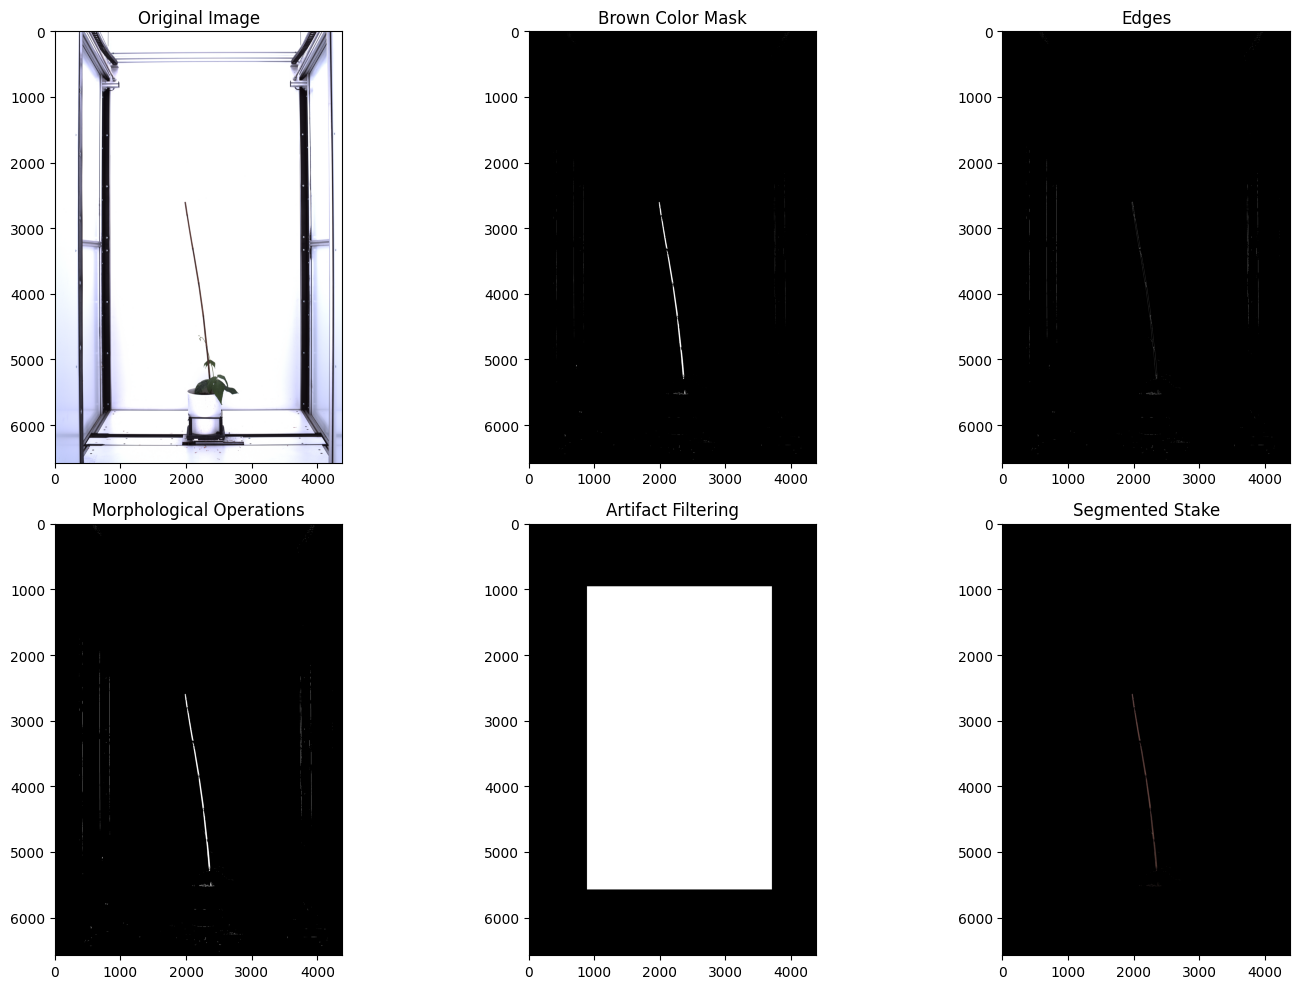

In [13]:
segment(image_path)

Processing:
Prediction: output/8-28-23-HerbsMaize-InHouse_828-091-BeanDragon-WW_2023-08-29_13-35-50.743_17880100_Vis_SV_0/combined_mask.png
Ground Truth: ground_truth/8-28-23-HerbsMaize-InHouse_828-091-BeanDragon-WW_2023-08-29_13-35-50.743_17880100_Vis_SV_0_ground_truth.png


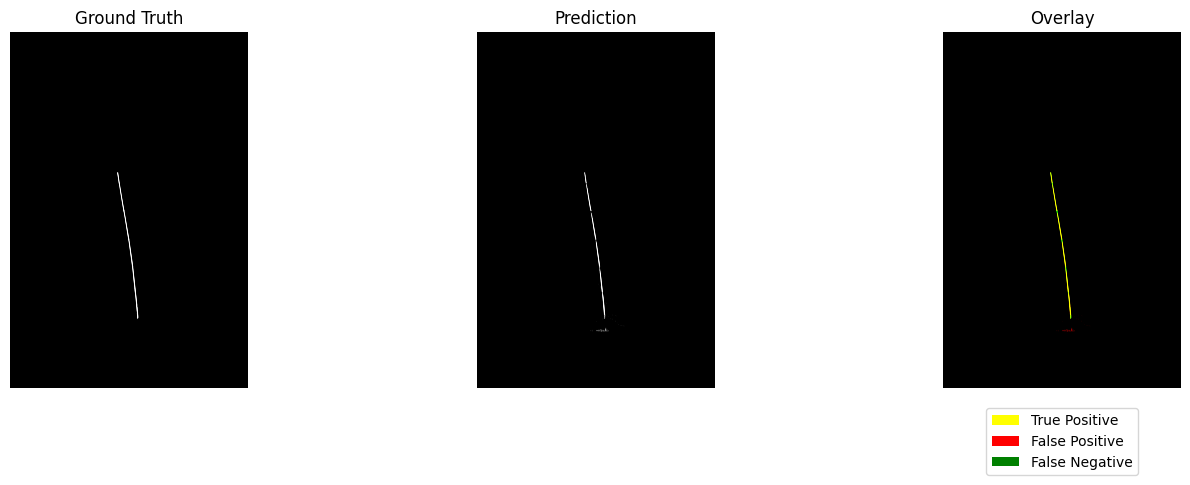

In [ ]:
class SegmentationEvaluator:
    """
    Evaluate image segmentation results using various metrics and compares predicted segmentation masks against ground truth masks.
    """
    def __init__(self, pred_mask, true_mask):
        self.pred_mask = pred_mask
        self.true_mask = true_mask
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(
            true_mask.ravel(),
            pred_mask.ravel()
        ).ravel()

    def iou(self):
        """
        Intersection over Union (IoU) / Jaccard index. Returns ratio of intersection to union of predicted and ground truth mask.
        """
        intersection = self.tp
        union = self.tp + self.fp + self.fn
        return intersection / union if union != 0 else 0

    def dice_coefficient(self):
        # Dice coefficient (F1 score). Returns harmonic mean of precision and recall.
        return 2 * self.tp / (2 * self.tp + self.fp + self.fn) if (2 * self.tp + self.fp + self.fn) != 0 else 0

    def precision(self):
        # Positive predictive value
        return self.tp / (self.tp + self.fp) if (self.tp + self.fp) != 0 else 0

    def recall(self):
        # Sensitivity
        return self.tp / (self.tp + self.fn) if (self.tp + self.fn) != 0 else 0

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    @staticmethod
    def _get_boundary(mask):
        # Get boundary from mask with morphological operations
        dilated = binary_dilation(mask)
        eroded = binary_erosion(mask)
        return dilated ^ eroded

    def get_all_metrics(self):
            return {
                'IoU': self.iou(),
                'Dice': self.dice_coefficient(),
                'Recall': self.recall(),
                'Precision': self.precision(),
                'Accuracy': self.accuracy()
            }

    def visualize_results(self, save_path=None):
        # Return visualization of segmentation results.
       fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

       ax1.imshow(self.true_mask, cmap='gray')
       ax1.set_title('Ground Truth')
       ax1.axis('off')

       ax2.imshow(self.pred_mask, cmap='gray')
       ax2.set_title('Prediction')
       ax2.axis('off')

       overlap = np.zeros((*self.true_mask.shape, 3))
       overlap[self.true_mask == 1] = [0, 1, 0]
       overlap[self.pred_mask == 1] = [1, 0, 0]
       overlap[(self.true_mask == 1) & (self.pred_mask == 1)] = [1, 1, 0]

       ax3.imshow(overlap)
       ax3.set_title('Overlay')
       ax3.axis('off')

       from matplotlib.patches import Patch
       legend_elements = [
           Patch(facecolor='yellow', label='True Positive'),
           Patch(facecolor='red', label='False Positive'),
           Patch(facecolor='green', label='False Negative')
       ]

       ax3.legend(handles=legend_elements,
                 loc='center',
                 bbox_to_anchor=(0.5, -0.15),
                 ncol=1)

       plt.tight_layout()

       if save_path:
           plt.savefig(save_path,
                      bbox_inches='tight',
                      dpi=300,
                      pad_inches=0.5)

           overlay_path = save_path.replace('.png', '_overlay.png')
           fig_overlay, ax_overlay = plt.subplots(figsize=(8, 8))
           ax_overlay.imshow(overlap)
           ax_overlay.set_title('Segmentation Overlay')
           ax_overlay.axis('off')
           ax_overlay.legend(handles=legend_elements,
                            loc='center',
                            bbox_to_anchor=(0.5, -0.1),
                            ncol=1)
           plt.tight_layout()
           plt.savefig(overlay_path,
                       bbox_inches='tight',
                       dpi=300,
                       pad_inches=0.5)
           plt.close(fig_overlay)

       plt.show()
       plt.close(fig)

def evaluate_segmentation(pred_img, gt_img, output_folder):
    # Evaluate segmentation results for all images in given folder
    os.makedirs(output_folder, exist_ok=True)
    result_file = os.path.join(output_folder, "Segmentation_Evaluation_Results.txt")

    with open(result_file, "w") as f:
            # pred_file = "8-28-23-HerbsMaize-InHouse_828-091-BeanDragon-WW_2023-08-29_13-35-50.743_17880100_Vis_SV_0/segmented_stem.png"
            # matching_gt = "8-28-23-HerbsMaize-InHouse_828-091-BeanDragon-WW_2023-08-29_13-35-50.743_17880100_Vis_SV_0_ground_truth.png"
            
            print(f"Processing:\nPrediction: {pred_img}\nGround Truth: {gt_img}")

            pred_img = Image.open(pred_img).convert('L')
            true_img = Image.open(gt_img).convert('L')

            pred_mask = np.array(pred_img) > 127
            true_mask = np.array(true_img) > 127

            evaluator = SegmentationEvaluator(pred_mask, true_mask)
            metrics = evaluator.get_all_metrics()

            f.write(f"File: {pred_img}\n")
            for metric, value in metrics.items():
                f.write(f"{metric}: {value:.4f}\n")
            f.write("\n")

            eval_visualization_path = os.path.join(
                output_folder,
                "combined_mask_evaluation_visualization.png"
            )
            evaluator.visualize_results(save_path=eval_visualization_path)

prediction = "output/8-28-23-HerbsMaize-InHouse_828-091-BeanDragon-WW_2023-08-29_13-35-50.743_17880100_Vis_SV_0/combined_mask.png"
ground_truth = "ground_truth/8-28-23-HerbsMaize-InHouse_828-091-BeanDragon-WW_2023-08-29_13-35-50.743_17880100_Vis_SV_0_ground_truth.png"
output_folder = "evaluation/" + image_path

evaluate_segmentation(prediction, ground_truth, output_folder)